# EDA: Dead cells

This notebook is intended to help with the validation of the intensity-based filtering for dead cells by analyzing their empirical distribution and comparing those to the ones of healthy cells.

Note that the analyses are not exhaustive.

---
## 0. Environmental setup

In [14]:

%load_ext autoreload
import sys
sys.path.append("..")

import cv2
import numpy as np
import matplotlib.pyplot as plt
from src.utils.io import get_file_list
import random
import tifffile

np.random.seed(1234)
random.seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


----
## 1. Read in data

In [319]:
root_dir = '../data/tcell_project/filtered/area_filtered/filtered'
file_list = get_file_list(root_dir)
# The IDs are set manually by inspecting the plotted slides.
dead_cell_ids = [19, 22, 52, 66, 79, 91, 167, 174, 179, 
                   186, 204, 267, 270, 301, 310, 322, 332, 339, 377, 
                   378]
healhty_cell_ids = list(range(19))+[20,21]

In [325]:
dead_cells = []
healthy_cells = []

for i in range(len(dead_cell_ids)):
    dead_cells.append(np.squeeze(tifffile.imread(file_list[dead_cell_ids[i]])))
    healthy_cells.append(np.squeeze(tifffile.imread(file_list[healhty_cell_ids[i]])))

We will now plot a couple of those dead cells and a couple living cells to make them better comparable. Note that we will plot only the maximum projection along the z-axis.

### Healthy cells

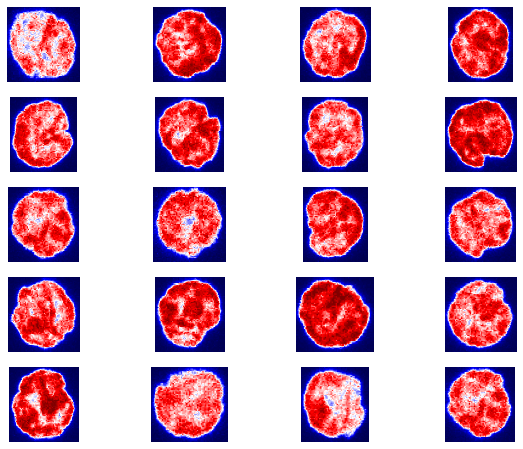

In [73]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=[10,8])
axes = axes.flatten()
for i in range(len(healthy_cells)):
    axes[i].imshow(np.max(healthy_cells[i], axis=0), 
                         cmap='seismic')
    axes[i].axis('off')

### Dead cells

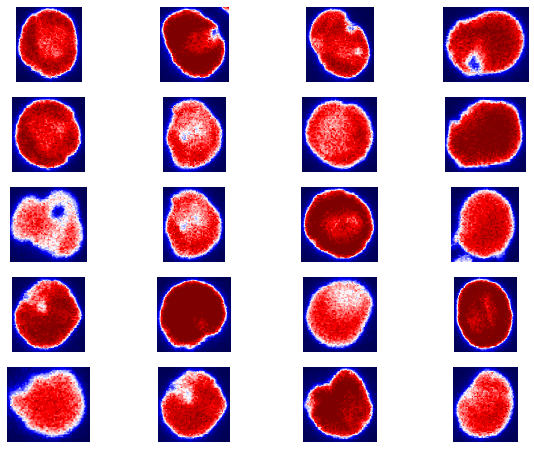

In [79]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=[10,8])
axes = axes.flatten()
for i in range(len(healthy_cells)):
    axes[i].imshow(np.max(dead_cells[i], axis=0), 
                         cmap='seismic')
    axes[i].axis('off')

As we can see the dead cells show a very homogenous structure with not many intensity changes within the nucleus except for a couple holes that are often seen.

----

## 2. Histogram analysis

We will thus compare the histograms of the individual cells to check if those histograms illustrate the visible differences differences.

### Healthy cells

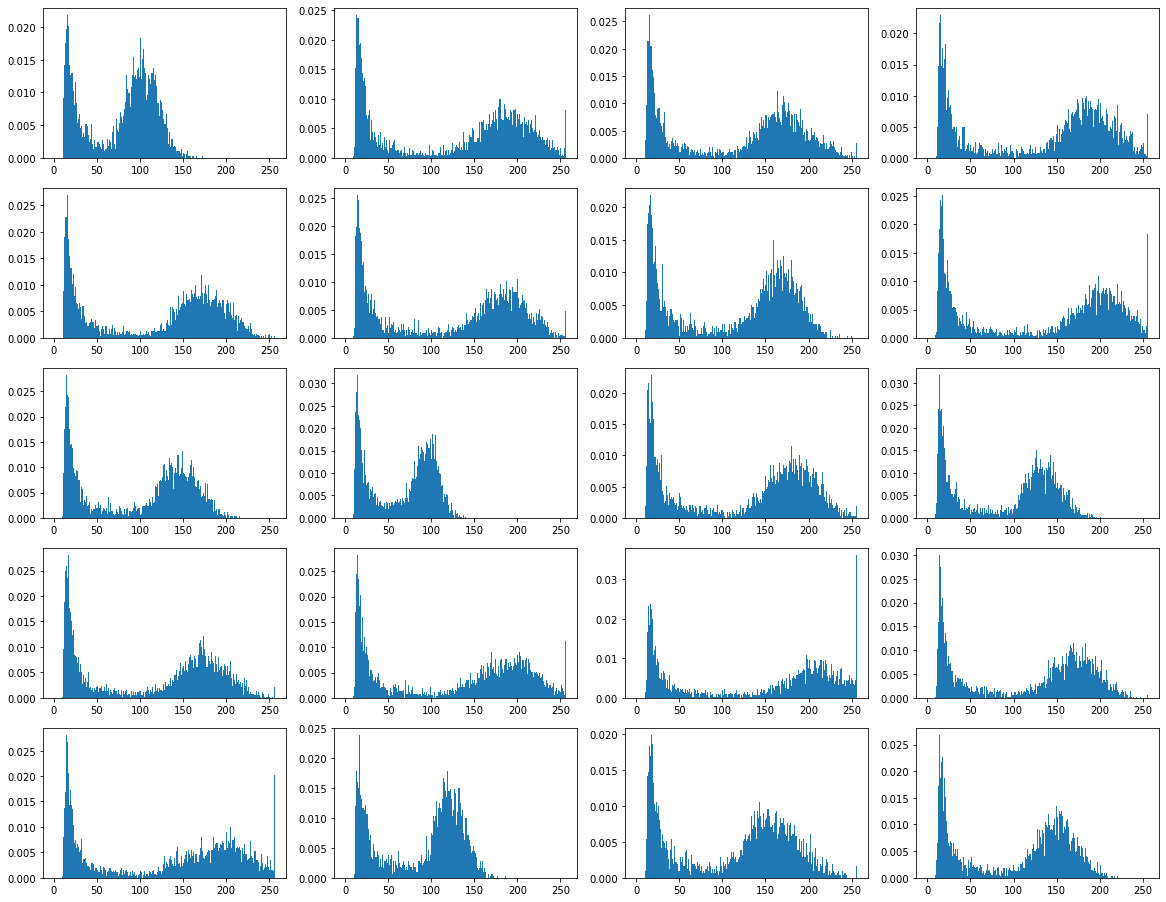

In [313]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=[20,16])
axes = axes.flatten()
for i in range(len(healthy_cells)):
    axes[i].hist(np.max(healthy_cells[i], axis=0).ravel(), 256, 
                 [0,256], density=True)

### Dead cells

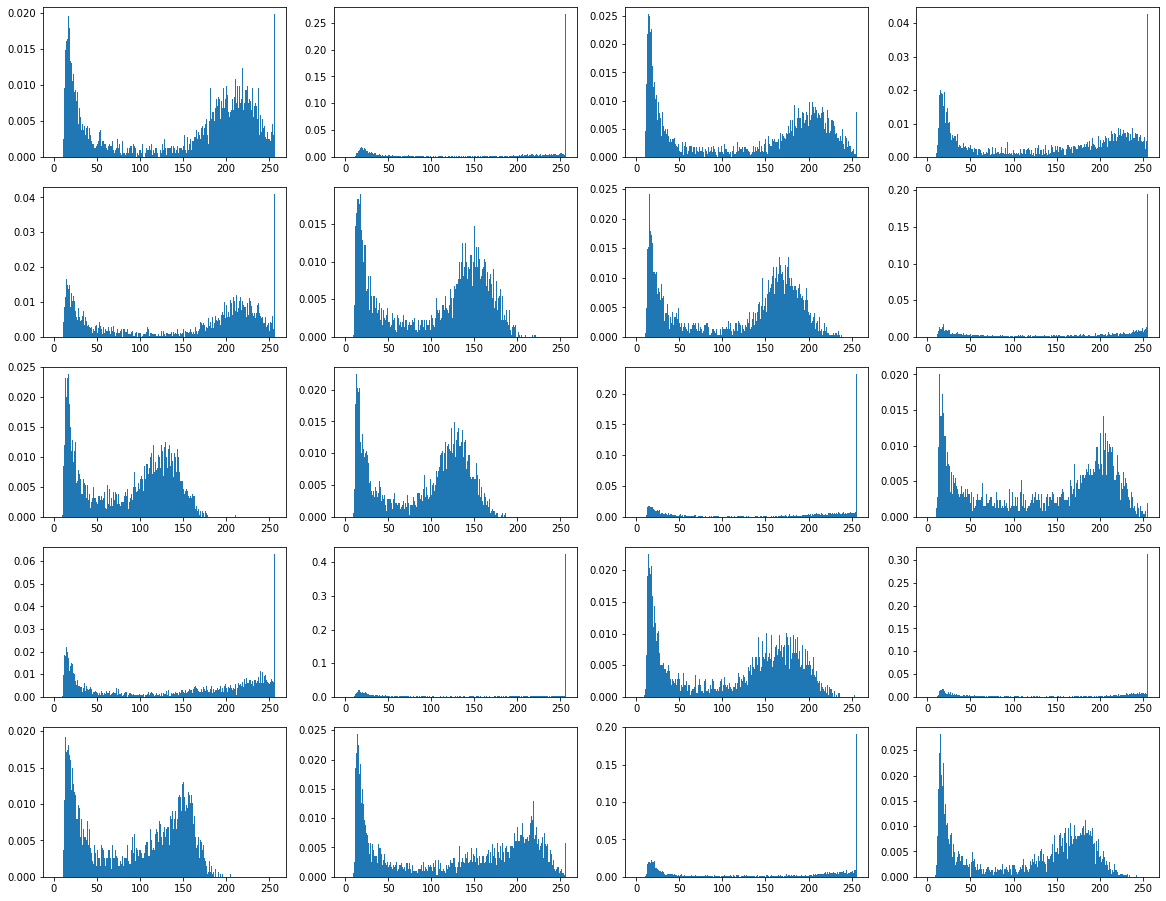

In [314]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=[20,16])
axes = axes.flatten()
for i in range(len(healthy_cells)):
    axes[i].hist(np.max(dead_cells[i], axis=0).ravel(), 256, [0,256], 
                 density=True)

We see that for some dead cells very high intensity values dominate the max-z projection. As a consequence setting a threshold on the percentage of intensity values of 254 or higher relative to the total number of pixels might be an option to filter some of the dead cells out. However, there are also those dead cells that have holes or areas of fading intensity. For those the histograms look relatively comparable to the ones of the healthy cells. Hence an approach that filters cells showing no or only very little DNA structure could be more promising.

---
## 3. Structure analysis

Many different approaches based on edge detection to quantify the amount of visible structure of the DNA in the nuclei failed to distinguish between the healthy and dead cells.

A rather simple, not perfect and somewhat error-prone method could be qantifying the structure by applying a thresholding approach to filter for medium intensity structures, that we typically see within in the nuclei as consequence of the chromatin structures. For dead cells we see a lack of such structure. This is shown below

### Healthy cells

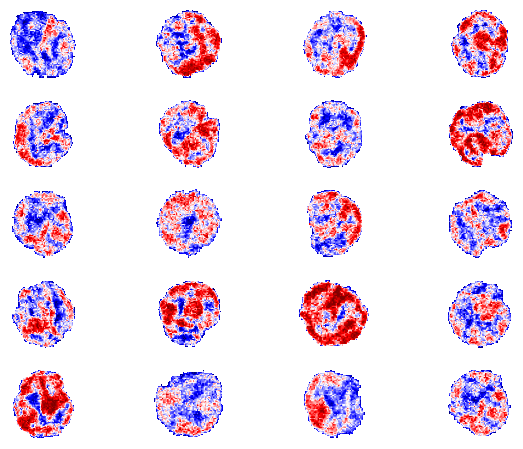

In [333]:
from skimage.feature import canny
from skimage.filters import sobel
from scipy import ndimage as ndi
from skimage.filters import threshold_otsu
from numpy import ma

contrasts_healthy = []

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=[10,8])
axes = axes.flatten()
for i in range(len(healthy_cells)):
    imz = healthy_cells[i]/healthy_cells[i].max()
    imz *= 255
    imz = np.uint8(imz)
    imz = np.max(imz, axis=0) 
    thresh = threshold_otsu(imz)
    nuclei_mask = imz >= thresh
    edges = canny(imz)
    #nuclei_mask[edges] = True
    nuclei_mask = ndi.binary_fill_holes(nuclei_mask)
    
    mdata = ma.masked_array(imz, mask=~nuclei_mask)
    contrasts_healthy.append(mdata.mean())
    
    axes[i].imshow(mdata, cmap='seismic')
    #axes[i].hist(mdata.ravel(), 256, [0,256])
    axes[i].axis('off')

### Dead cells

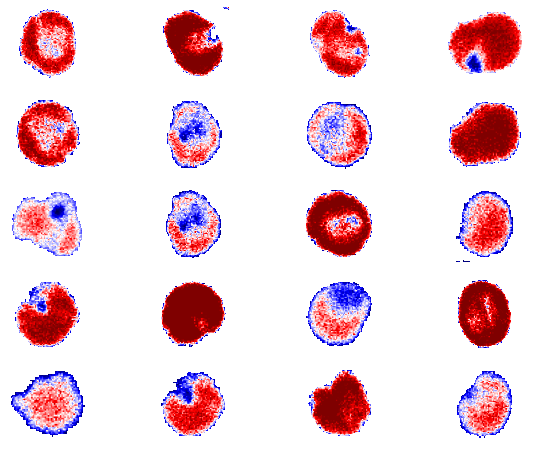

In [334]:
contrasts_dead = []

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=[10,8])
axes = axes.flatten()
for i in range(len(dead_cells)):
    imz = dead_cells[i]/dead_cells[i].max()
    imz *= 255
    imz = np.uint8(imz)
    imz = np.max(imz, axis=0) 
    thresh = threshold_otsu(imz)
    nuclei_mask = imz >= thresh
    edges = canny(imz)
    #nuclei_mask[edges] = True
    nuclei_mask = ndi.binary_fill_holes(nuclei_mask)
    
    mdata = ma.masked_array(imz, mask=~nuclei_mask)
    contrasts_dead.append(mdata.mean())
    
    #axes[i].hist(mdata.ravel(), 256, [0,256])
    axes[i].imshow(mdata, cmap='seismic')
    axes[i].axis('off')

At the time being a more sophisticated method for filtering the dead cells is not yet known as typical filters based on the circularity does not work for circular cells like T-cells.

Thus we will for know only filter those out that show an extraordinarly large amount of high intensity values, i.e. those with a amount larger than a predefined treshold. From the histograms above 5% seems to be a good threshold for intensity values > 254 after normalizing the image.